In [193]:
####################################
# Autor:Renato Sebastian Ramirez Calva
#
# Descripcion: Este modelo estudia el comportamiento de uno o varios robots en una habitacion
# en la cual deben limpiar las celdas que se encuentran sucias
#
# Fecha de creacion: 27/11/2022
####################################


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [264]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime
import random

In [265]:
#def get_grid(model):
#    agent_counts = np.zeros((model.grid.width, model.grid.height))
#    w=model.grid.width
#    df=pd.DataFrame(agent_counts)
#    for cell in model.grid.coord_iter():
#        agents, x, y = cell
#        c=None
#        for a in agents:
#            c = a.isActive
#        df.iloc[x,y] = c
#    return df

def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (content, x, y) in model.grid.coord_iter(): 
        for a in content:
            grid[x][y] = a.isActive
    return grid

In [272]:

class Robot(Agent):
    def __init__(self, uid, model, x, y):
      super().__init__(uid, model)
      self.isActive = True
      self.y = y
      self.x = x
      self.type = "Robot"


    def step(self):
        self.clean()

###########################################################
# Obtiene los vecinos cercanos en 8 casilla alrededor, 
# si hay suciedad se movera hacia esa casilla y se limpiara
###########################################################
    def clean(self):
        neighbours = self.model.grid.get_neighbors(self.pos, moore=True, include_center=True)
        rand = random.choice(neighbours)
        if rand.type == "Robot":
            return
        else:
            self.model.grid.move_agent(self, rand)
            if rand.type == "Dirt":
                rand.cleaned(rand)   

    
        
    

In [273]:
class Dirt(Agent):
    def __init__(self, uid, model, x, y):
      super().__init__(uid, model)
      self.isActive = True
      self.y = y
      self.x = x
      self.type = "Dirt"
      self.existance = 0

##########################################################
# La suciedad es removida y su posicion es seteada como None
##########################################################
    def cleaned(self):
        self.model.grid.remove_agent(self)
        self.model.out.append(self)


    def step(self):
        self.existance += 1

    

In [274]:
class House(Model):
      
      def __init__(self, width, height):
        self.uids = 1
        self.grid = MultiGrid(width, height, False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        #Numero de agentes
        self.robots = 5
        self.dirts = 150
        #Suciedad limpiada
        self.out = []

        for robot in range(self.robots):
              agent = Robot(self.uids, self, 1, 1)
              self.grid.place_agent(agent, (1, 1))
              self.schedule.add(agent)
              self.uids += 1
        for dirt in range(self.dirts):
              cell = self.grid.find_empty()
              agent = Dirt(self.uids, self, 1, 1)
              self.grid.place_agent(agent, cell)
              self.schedule.add(agent)
              self.uids += 1

      def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
        for agent in self.out:
            self.schedule.remove(agent)

        self.out = []


In [282]:
WIDTH = 30
HEIGHT = 30
MAX_ITERATIONS = 99


start_time = time.time()
model = House(WIDTH, HEIGHT)
per_dirt = (model.dirts/(WIDTH*HEIGHT))

print("Numero de agentes tanto suciedad como robots")
print(model.dirts)
print(model.robots)
agents_steps = 0


for i in range(MAX_ITERATIONS):
    model.step()

agents_steps = (MAX_ITERATIONS * model.robots)
print("Numero de pasos por los agentes", agents_steps)
print("Tiempo de ejcucion: ", str(datetime.timedelta( seconds = (time.time() - start_time))))

Numero de agentes tanto suciedad como robots
150
5
Numero de pasos por los agentes 495
Tiempo de ejcucion:  0:00:00.077702


In [283]:
all_grid = model.datacollector.get_model_vars_dataframe()
print(all_grid)

                                                 Grid
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
2   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
..                                                ...
94  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
95  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
96  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
97  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
98  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...

[99 rows x 1 columns]


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-246-c771ea916426>", line 7, in animate
    patch.set_data(all_grid.iloc[0][0], cmap = plt.cm.binary)
TypeError: set_data() got an unexpected keyword argument 'cmap'


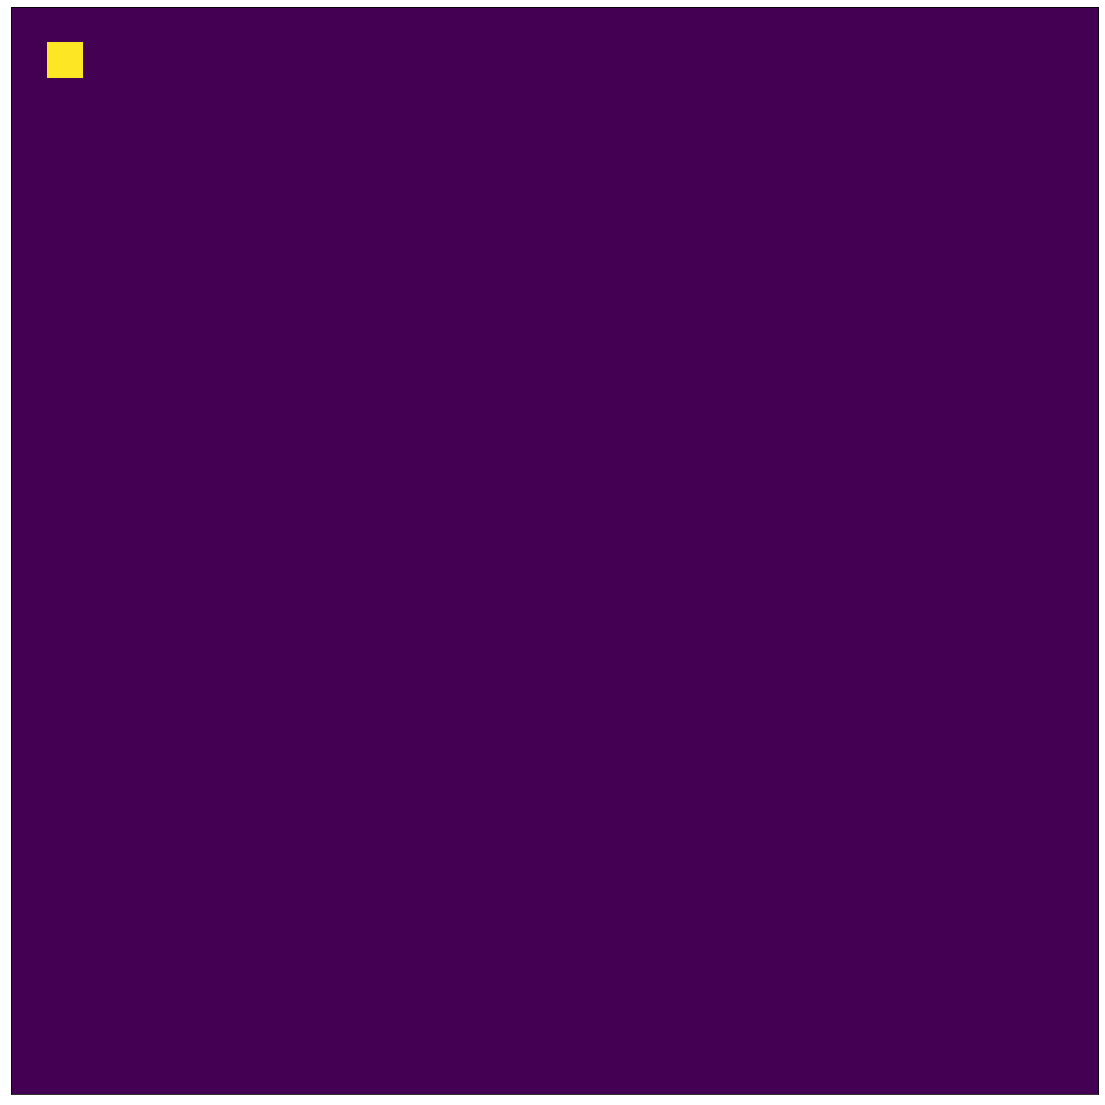

In [246]:
fig, axs = plt.subplots(figsize = (20, 20))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[i][0])

def animate(i):
    patch.set_data(all_grid.iloc[0][0], cmap = plt.cm.binary)

anim = animation.FuncAnimation(fig, animate, frames = MAX_ITERATIONS)

In [192]:
anim

TypeError: ignored